In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
df = pd.read_csv('../data/yield_final.csv')

In [3]:
categorical = ['country','crop', 'year']
numerical = ['average_rain_fall_mm_per_year',
 'pesticide_tonnes',
 'avg_temp']

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)

y_train = df_train.yield_hg_ha.values
y_test = df_test.yield_hg_ha.values
y_val = df_val.yield_hg_ha.values

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

del df_train['yield_hg_ha']
del df_test['yield_hg_ha']
del df_val['yield_hg_ha']

In [6]:
# Log-transform highly skewed numerical features
skewed_features = ['pesticide_tonnes', 'average_rain_fall_mm_per_year']
for col in skewed_features:
    df_train[col] = np.log1p(df_train[col])
    df_val[col] = np.log1p(df_val[col])
    df_test[col] = np.log1p(df_test[col])

In [7]:
scaler = StandardScaler()
df_train[numerical] = scaler.fit_transform(df_train[numerical])
df_val[numerical] = scaler.transform(df_val[numerical])
df_test[numerical] = scaler.transform(df_test[numerical])


In [8]:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    #feature_names = dv.get_feature_names_out()
    
    #print(feature_names)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

In [9]:
# Train the model
dv, model = train(df_train, y_train_log)

# Predict on validation/test set
y_pred_val_log = predict(df_val, dv, model)  # predictions in log scale
y_pred_val = np.expm1(y_pred_val_log)        # convert back to original units

y_pred_test_log = predict(df_test, dv, model)
y_pred_test = np.expm1(y_pred_test_log)

# Evaluate on validation set (original units)
mse = mean_squared_error(y_val, y_pred_val)  # compare with y_val in original units
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print("Validation RMSE:", rmse)
print("MAE:", mae)
print("Validation R2:", r2)

Validation RMSE: 37364.657196581524
MAE: 21836.710189452457
Validation R2: 0.7867100068473064


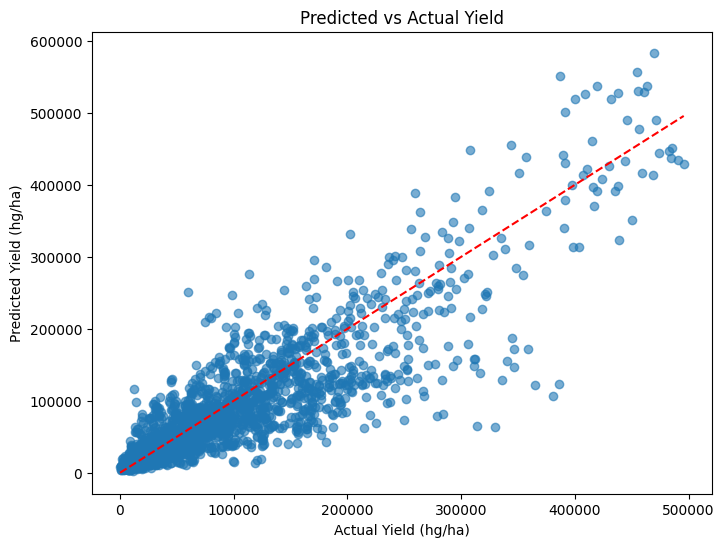

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Yield (hg/ha)")
plt.ylabel("Predicted Yield (hg/ha)")
plt.title("Predicted vs Actual Yield")
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(y_val - y_pred_val, bins=50, color='yellow', edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()
